# Rapidly Exploring Random Tree (RRT) Path Planning

In [1]:
import numpy as np
from dataclasses import dataclass
from scipy.spatial import KDTree
from typing import Optional


@dataclass
class Node:
    state: np.ndarray
    parent: Optional['Node']


def find_nearest_node(nodes: [Node], x_sample: np.ndarray) -> Node:
    """Find the nearest node to x_samp."""
    xs = np.array([node.state for node in nodes])
    tree = KDTree(xs)
    nearest_dist, nearest_ind = tree.query(x_sample)
    return nodes[nearest_ind]


def local_planner(x1: np.ndarray, x2: np.ndarray, illegal_region: np.ndarray) -> Optional[np.ndarray]:
    """Use a local planner to find a transition from x1 to x2."""
    dx = (x2 - x1)
    dxn = dx / np.linalg.norm(dx)
    x_new = x1 + 0.25 * dxn  # Naive transition  

    # Check if the transition is illegal by checking if it is inside the illegal region
    if np.all(illegal_region[0] < x_new) and np.all(x_new < illegal_region[2]):
        return None

    return x_new


def is_goal(x: np.ndarray, x_goal: np.ndarray, tol: float = 0.5) -> bool:
    """Check if x is within tol of x_goal."""
    return np.linalg.norm(x - x_goal) < tol


def rrt(x_start: np.ndarray, x_goal: np.ndarray, illegal_region: np.ndarray) -> [Node]:
    """RRT algorithm. See Lynch and Park (p. 381)."""
    xs = [x_start]
    nodes = [Node(x_start, None)]

    # Add the start node to the tree
    T_max = 300
    while len(xs) < T_max:
        # Sample from the space and find the nearest state to the sample
        # Add bias towards the goal        
        if np.random.uniform(0, 1) < 0.1:
            x_sample = x_goal
        else:
            x_sample = np.array([np.random.uniform(0, 10), np.random.uniform(0, 10)])

        node_nearest = find_nearest_node(nodes, x_sample)

        # Use a local planner to find a transition from x_nearest to x_new
        x_new = local_planner(node_nearest.state, x_sample, illegal_region)
        if x_new is None:
            continue

        nodes.append(Node(x_new, node_nearest))
        xs.append(x_new)

        if is_goal(x_new, x_goal):
            nodes.append(Node(x_goal, nodes[-1]))
            return nodes
    return nodes


x_start = np.array([0., 0.])
x_goal = np.array([10., 10.])
illegal_region = np.array([[3, 3], [3, 5], [5, 5], [5, 3]])
nodes = rrt(x_start, x_goal, illegal_region)


In [2]:
def rrt_to_trajectory(nodes: [Node]) -> Optional[np.ndarray]:
    """Convert the RRT nodes to a trajectory."""
    if not is_goal(nodes[-1].state, x_goal):
        # No path found
        return None
        
    trajectory = [nodes[-1].state]
    parent = nodes[-1].parent
    while parent is not None:
        trajectory.append(parent.state)
        parent = parent.parent
    return np.array(trajectory[::-1])

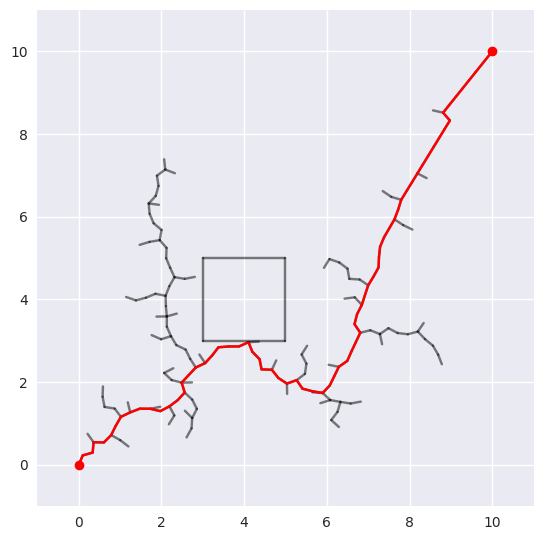

In [3]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

fig, ax = plt.subplots()

# Plot the tree
edges = [(node.state, node.parent.state) for node in nodes if node.parent is not None]
for edge in edges:
    ax.plot([edge[0][0], edge[1][0]], [edge[0][1], edge[1][1]], 'k-', alpha=0.5)

# Plot the path
xs = rrt_to_trajectory(nodes)
ax.plot(xs[:, 0], xs[:, 1], 'r-')

# Start and goal
ax.plot(x_start[0], x_start[1], 'ro')
ax.plot(x_goal[0], x_goal[1], 'ro')

# Illegal region
for i in range(4):
    p1 = illegal_region[i]
    p2 = illegal_region[(i + 1) % 4]
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-', alpha=0.5)

ax.set_xlim([-1, 11])
ax.set_ylim([-1, 11])
ax.set_aspect('equal', 'box')

plt.tight_layout()
plt.show()



In [4]:
from scipy.interpolate import splprep, splev
tck, u = splprep(xs.T, s=2)
x_new, y_new = splev(np.linspace(0, 1, 100), tck)
xs_new = np.array([x_new, y_new]).T

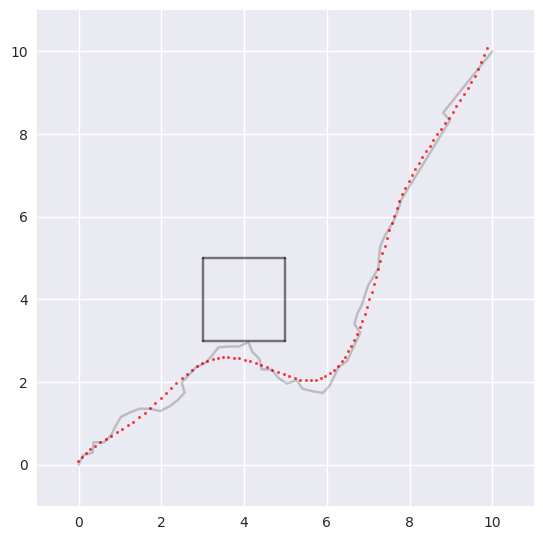

In [5]:
# Plot the splines
fig, ax = plt.subplots()

ax.plot(xs[:, 0], xs[:, 1], 'k-', alpha=0.2)
ax.scatter(x_new, y_new, c='r', s=3, alpha=0.8)

# Illegal region
for i in range(4):
    p1 = illegal_region[i]
    p2 = illegal_region[(i + 1) % 4]
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-', alpha=0.5)

ax.set_xlim([-1, 11])
ax.set_ylim([-1, 11])
ax.set_aspect('equal', 'box')

plt.tight_layout()
plt.show()

# Model Predictive Control

In [6]:
import jax
import jax.numpy as jnp
import diffrax
import optax


def solve_mpc(state: np.ndarray, ref: np.ndarray, dt: float = 0.1, l: float = 1.0,
              n_steps: int = 500, lr: float = 0.05):
    """Solve the MPC problem using JAX single-shooting with Diffrax + Optax.

    @param state: The initial state of the system (x, y, v, theta)
    @param ref: The x, y reference trajectory (horizon x 2)
    @param dt: Time step
    @param l: Wheelbase length
    @param n_steps: Number of optimization steps
    @param lr: Learning rate for Adam optimizer
    @return: Dictionary with planned states and controls
    """
    N = 100  # number of discretization steps
    horizon = ref.shape[0]
    DT = horizon * dt
    t_grid = jnp.linspace(0, DT, N + 1)

    u_a_max = 3.0
    u_omega_max = jnp.pi / 2

    ref_jnp = jnp.array(ref, dtype=jnp.float32)
    state_jnp = jnp.array(state, dtype=jnp.float32)
    indices = jnp.arange(len(ref), dtype=jnp.float32)
    ref_x = ref_jnp[:, 0]
    ref_y = ref_jnp[:, 1]

    def ode(t, y, u_params):
        """Bicycle kinematic model ODE."""
        x, y_pos, v, theta = y
        u_a_all, u_omega_all = u_params
        u_a = jnp.interp(t, t_grid, u_a_all)
        u_omega = jnp.interp(t, t_grid, u_omega_all)
        return jnp.array([
            v * jnp.cos(theta),
            v * jnp.sin(theta),
            u_a,
            v * u_omega / l,
        ])

    def forward_solve(u_a_c, u_omega_c):
        """Solve the ODE forward given clipped controls."""
        return diffrax.diffeqsolve(
            diffrax.ODETerm(ode),
            diffrax.Tsit5(),
            t0=0, t1=DT, dt0=DT / N,
            y0=state_jnp,
            args=(u_a_c, u_omega_c),
            saveat=diffrax.SaveAt(ts=t_grid),
            max_steps=10000,
        )

    @jax.jit
    def solve_and_cost(u_params):
        """Solve the ODE and compute the tracking + control cost."""
        u_a_c = jnp.clip(u_params[0], -u_a_max, u_a_max)
        u_omega_c = jnp.clip(u_params[1], -u_omega_max, u_omega_max)

        sol = forward_solve(u_a_c, u_omega_c)
        x_sol = sol.ys[:, 0]
        y_sol = sol.ys[:, 1]

        # Interpolate reference trajectory onto the time grid
        x_ref = jnp.interp(t_grid / dt, indices, ref_x)
        y_ref = jnp.interp(t_grid / dt, indices, ref_y)

        # Running cost: control effort + tracking error
        cost = jnp.trapezoid(
            u_a_c**2 + u_omega_c**2 + 10 * (x_ref - x_sol)**2 + 10 * (y_ref - y_sol)**2,
            t_grid,
        )
        return cost

    # Optimize controls with Adam
    u_params = jnp.zeros((2, N + 1))
    optimizer = optax.adam(learning_rate=lr)
    opt_state = optimizer.init(u_params)

    @jax.jit
    def opt_loop(u_params, opt_state):
        def step(carry, _):
            u, os = carry
            cost, grads = jax.value_and_grad(solve_and_cost)(u)
            updates, os = optimizer.update(grads, os, u)
            u = optax.apply_updates(u, updates)
            u = u.at[0].set(jnp.clip(u[0], -u_a_max, u_a_max))
            u = u.at[1].set(jnp.clip(u[1], -u_omega_max, u_omega_max))
            return (u, os), cost
        return jax.lax.scan(step, (u_params, opt_state), None, length=n_steps)

    (u_opt, _), costs = opt_loop(u_params, opt_state)

    # Extract final trajectory
    u_a_opt = jnp.clip(u_opt[0], -u_a_max, u_a_max)
    u_omega_opt = jnp.clip(u_opt[1], -u_omega_max, u_omega_max)
    sol = forward_solve(u_a_opt, u_omega_opt)

    return {
        "x": np.asarray(sol.ys[:, 0]),
        "y": np.asarray(sol.ys[:, 1]),
        "v": np.asarray(sol.ys[:, 2]),
        "theta": np.asarray(sol.ys[:, 3]),
        "u_a": np.asarray(u_a_opt),
        "u_omega": np.asarray(u_omega_opt),
        "costs": np.asarray(costs),
    }

In [7]:
def get_reference_trajectory(state: np.ndarray, xs: np.ndarray, horizon: int) -> np.ndarray:
    """Get the reference trajectory from xs by finding the point that is closest to the current state"""
    distances = np.linalg.norm(xs - state[:2], axis=1)
    closest_index = np.argmin(distances)
    
    if closest_index + horizon > xs.shape[0]:
        return xs[closest_index:]
    else:
        return xs[closest_index:closest_index + horizon]

In [8]:
current_state = np.array([0, 0, 0, 0], dtype=float)
# Plan a trajectory
nodes = rrt(current_state[:2], x_goal, illegal_region)
xs = rrt_to_trajectory(nodes)

x_bars = []
y_bars = []
v_bars = []
theta_bars = []
u_as = []
u_omegas = []

# Model predictive control
for i in range(5):
    horizon = 10
    dt = 0.1

    # Take next points from the reference trajectory
    ref = get_reference_trajectory(current_state, xs, horizon)

    # Solve the MPC problem with JAX/Diffrax
    sol = solve_mpc(current_state, ref, dt, l=1.0)

    x_bars.append(sol["x"])
    y_bars.append(sol["y"])
    v_bars.append(sol["v"])
    theta_bars.append(sol["theta"])
    u_as.append(sol["u_a"])
    u_omegas.append(sol["u_omega"])

    current_state = np.array(
        [sol["x"][-1], sol["y"][-1], sol["v"][-1], sol["theta"][-1]]
    )

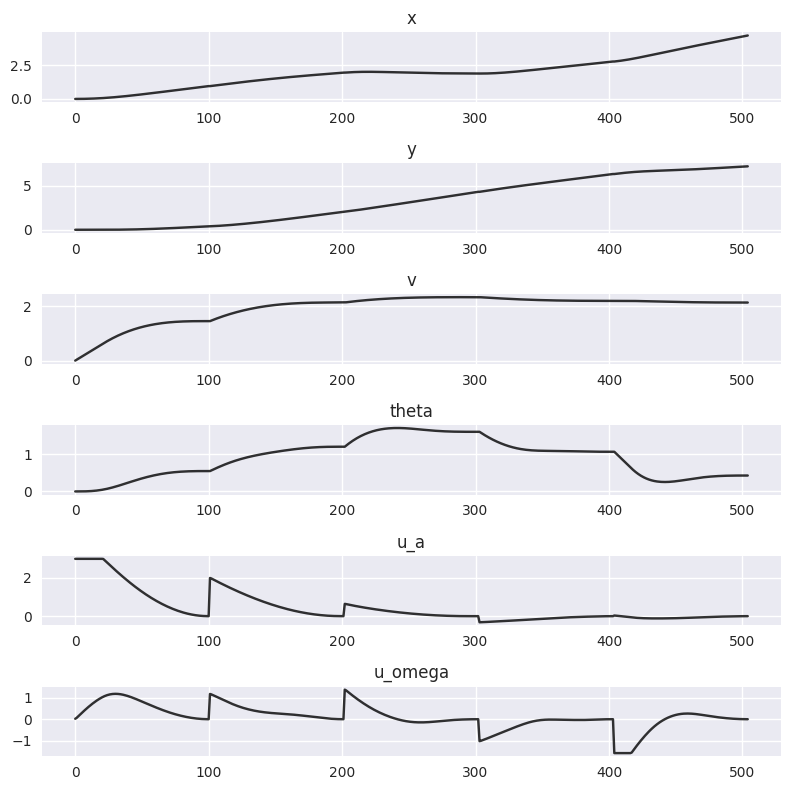

In [9]:
x_bars = np.hstack(x_bars)
y_bars = np.hstack(y_bars)
v_bars = np.hstack(v_bars)
theta_bars = np.hstack(theta_bars)
u_as = np.hstack(u_as)
u_omegas = np.hstack(u_omegas)

# Plot x_bars, y_bars, v_bars, theta_bars, u_as, u_omegas
fig, ax = plt.subplots(6, 1, figsize=(8, 8))

ax[0].plot(np.arange(len(x_bars)), x_bars, 'k-', alpha=0.8)
ax[0].set_title('x')

ax[1].plot(np.arange(len(x_bars)), y_bars, 'k-', alpha=0.8)
ax[1].set_title('y')

ax[2].plot(np.arange(len(x_bars)), v_bars, 'k-', alpha=0.8)
ax[2].set_title('v')

ax[3].plot(np.arange(len(x_bars)), theta_bars, 'k-', alpha=0.8)
ax[3].set_title('theta')

ax[4].plot(np.arange(len(x_bars)), u_as, 'k-', alpha=0.8)
ax[4].set_title('u_a')

ax[5].plot(np.arange(len(x_bars)), u_omegas, 'k-', alpha=0.8)
ax[5].set_title('u_omega')


plt.tight_layout()
plt.show()


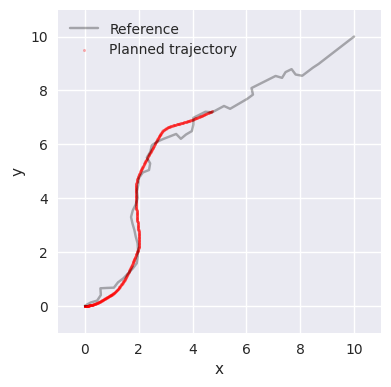

In [10]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# Plot the reference
ax.plot(xs[:, 0], xs[:, 1], 'k-', alpha=0.3, label='Reference')

# Plot the path plotted to follow the local planner
ax.scatter(x_bars, y_bars, c='r', s=3, alpha=0.3, label='Planned trajectory')

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.set_xlim([-1, 11])
ax.set_ylim([-1, 11])
ax.set_aspect('equal', 'box')
ax.legend()

plt.tight_layout()
plt.show()
